This is a project where I make models to predict biogas production using various machine learning techniques. The models were evaluated using 10-fold cross-validation, and this notebook contains summaries and visualizations of the models' performance. The data came from a paper entitled "Use of regression models for development of a simple and effective biogas decision-support tool" written by researchers Cuong Manh Tuong and Teng-Teeh Lim. The original data can be found in `.\\data\\for_model\\biogas.csv`.

In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import scikit_posthocs as sp
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib
import pickle

In [2]:
def plot_variables(df):
    fig, ax = plt.subplots(len(df.columns), len(df.columns))
    for axes in ax:
        for a in axes:
            a.set_xticklabels([])
            a.set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)
    colors = ['r', 'm', 'k', 'g', 'c', 'b']
    
    for (i, x) in enumerate(df.columns.values):
        for (j, y) in enumerate(df.columns.values):
            if i != j: 
                ax[j][i].scatter(df[x], df[y], s=0.5, color=colors[i], alpha=0.3)
                ax[j][i].margins(0.25, 0.25)
            else:
                ax[j][i].text(0.5, 0.5, x.replace('Temperature', 'Temp'), color=colors[i],
                              horizontalalignment='center',verticalalignment='center', transform=ax[i][j].transAxes)
                
            ax[i][j].tick_params(left=False, right=False , labelleft=False,
                                labelbottom=False, bottom=False)

INITIAL ANALYSES



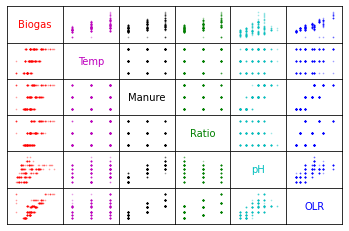

In [3]:
print('INITIAL ANALYSES\n')
df = pd.read_csv('data\\for_model\\biogas.csv')
del df['Essay']
plot_variables(df)

In [9]:
#visualize the results of a post-hoc nemenyi analysis on a cochran's q test using matplotlib in a matrix
def visualize_nemenyi(nemenyi_values, names):
    plt.matshow(nemenyi_values)
    ax = plt.gca()
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_xticklabels(labels=names,rotation=60)
    ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_yticklabels(labels=names)
    plt.title('Nemenyi post-hoc analysis on model similarity')
    
    #pulled these next two lines from stack overflow, just to display the values
    for (i, j), z in np.ndenumerate(nemenyi_values):
        ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
        
    plt.pause(0.1)

#evaluate a df of model values with column `Actual` being the actual classifications
def evaluate(model_df):
    '''
    Evaluate df of model answers, `Actual` being correct answers.
    Metric: RMSE.
    Prints out series with RMSE for each algorithm, Friedman Chi Square p-value and statistic,
    and post-hoc Nemenyi test results.
    '''
    actual = model_df['Actual'].to_numpy()
    model_df = model_df.drop('Actual', axis=1)
    models = model_df.to_numpy()
    (statistic, pvalue) = stats.friedmanchisquare(*models)
    print(f'Friedman chi squre test statistic: {statistic:.2f}, p-value: {pvalue:.5f}.\n')
    
    errors = (models.T - actual)**2
    mse = np.sqrt(np.mean(errors, axis=1))
    series = pd.Series(data=mse, index=model_df.columns.values).sort_values()
    standard_deviation = pd.read_csv('data\\for_model\\biogas.csv')['Biogas'].std()
    series = series.apply(lambda x: x/standard_deviation)
    
    series = series.apply(lambda x: f'{x:.3f}')
    print('Root mean squared errors over standard deviation:')
    print(series)
    
    nemenyi_result = sp.posthoc_nemenyi_friedman(models)
    visualize_nemenyi(nemenyi_result, model_df.columns.values)

MODEL EVALUATION

Resampling method: none
Friedman chi squre test statistic: 1891.38, p-value: 0.00000.

Root mean squared errors over standard deviation:
forest     0.167
regtree    0.171
xgboost    0.172
poly2      0.186
poly3      0.204
linear     0.224
l1         0.225
l2         0.228
dtype: object


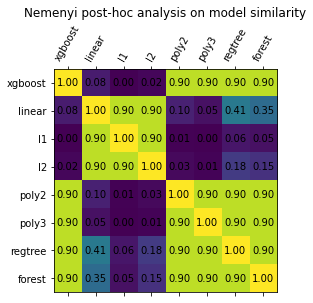


Resampling method: RandomOver
Friedman chi squre test statistic: 1891.75, p-value: 0.00000.

Root mean squared errors over standard deviation:
forest     0.169
regtree    0.173
xgboost    0.178
poly2      0.186
poly3      0.201
linear     0.225
l1         0.226
l2         0.228
dtype: object


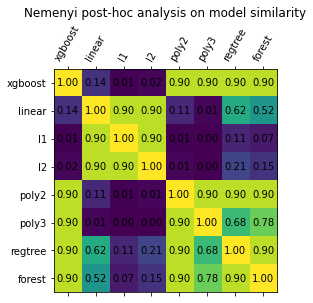


Resampling method: RandomUnder
Friedman chi squre test statistic: 1873.86, p-value: 0.00000.

Root mean squared errors over standard deviation:
forest     0.178
poly2      0.181
xgboost    0.183
regtree    0.184
linear     0.223
l1         0.225
l2         0.231
poly3      0.394
dtype: object


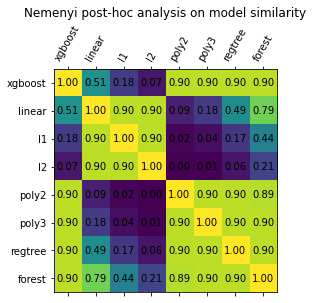

In [10]:
print('MODEL EVALUATION\n')
for method in ['none', 'RandomOver', 'RandomUnder']:
    print(f'Resampling method: {method}')
    models_df = pd.read_csv(f'.\\data\\for_model\\answers-{method}.csv')
    evaluate(models_df)
    print()

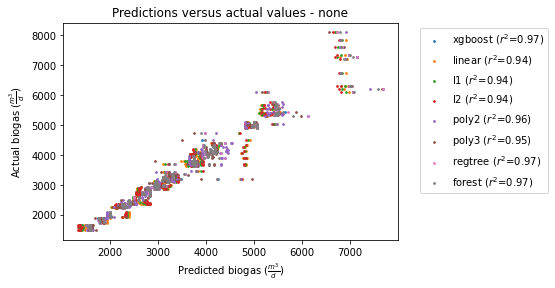

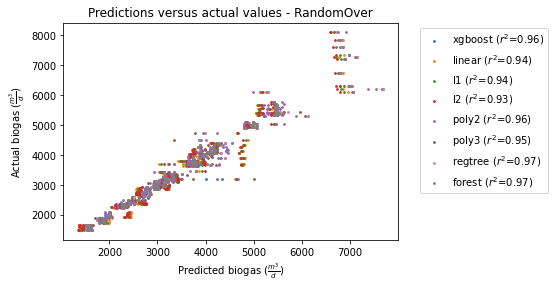

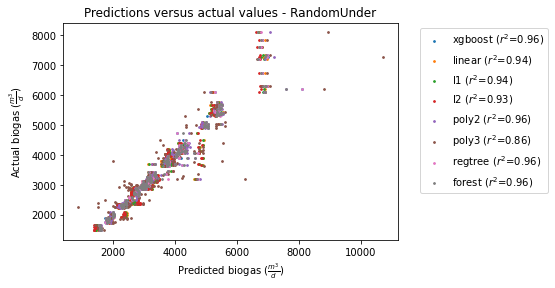

In [6]:
for method in ['none', 'RandomOver', 'RandomUnder']:
    models_df = pd.read_csv(f'.\\data\\for_model\\answers-{method}.csv')
    models = [column for column in models_df.columns.values if column != 'Actual']
    y = list(models_df['Actual'])
    fig, ax = plt.subplots()
    for model in models:
        x = list(models_df[model])
        r_squared = metrics.r2_score(x, y)
        ax.scatter(x, y, s=3, label=f'{model} ($r^2$={r_squared:.2f})')
        plt.title(f'Predictions versus actual values - {method}')
        ax.set_xlabel(r'Predicted biogas ($\frac{m^3}{d}$)')
        ax.set_ylabel(r'Actual biogas ($\frac{m^3}{d}$)')
        ax.legend(bbox_to_anchor=(1.05, 1))
        plt.plot()

In [7]:
def get_model_answers(df, predictor, output, model_name):
    to_predict_number = 1000
    df = df.drop(output, axis=1)
    index = list(df.columns.values).index(predictor)
    single_prediction = [df[column].mean() for column in df.columns.values]
    
    minimum, maximum = df[predictor].min(), df[predictor].max()
    predicted_length = (maximum - minimum) / to_predict_number
    to_predict_list = [(x * predicted_length) + minimum for x in range(to_predict_number+1)]
    with open(f'model\\saves\\{model_name}.pkl', 'rb') as f:
        model = pickle.load(f)
    
    final_to_predict = []
    for i in range(to_predict_number+1):
        to_add = single_prediction.copy()
        to_add[index] = to_predict_list[i]
        final_to_predict.append(to_add)
        
    if 'poly' in model_name:
        with open(f'model\\saves\\poly-{model_name}.pkl', 'rb') as f:
            poly = pickle.load(f)
        final_to_predict = poly.fit_transform(final_to_predict)
    
    predictions = model.predict(final_to_predict)
    return to_predict_list, predictions

def plot_model_variables(df, model):
    fig, ax = plt.subplots(2, len(df.columns)//2)
    for axes in ax:
        for a in axes:
            a.set_xticklabels([])
            a.set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)
    colors = [['r', 'm', 'k'], ['g', 'c', 'b']]
    j, k, i = 0, 0, 0
    y = 'Biogas'
    
    for x in df.columns.values:
        if k == 3:
            k = 0
            i = 1
        
        if i != j or k != j: 
            inputs, answers = get_model_answers(df, x, y, model)
            ax[i][k].plot(inputs, answers)
        
            ax[i][k].scatter(df[x], df[y], s=0.5, color=colors[i][k], alpha=0.3)
            ax[i][k].margins(0.25, 0.25)
            
            ax[i][k].text(0.5, 0.1, x, color=colors[i][k], horizontalalignment='center', verticalalignment='center',
                         transform = ax[i][k].transAxes)
        else:
            ax[i][k].text(0.5, 0.5, model, color=colors[i][k],
                          horizontalalignment='center',verticalalignment='center', transform=ax[i][k].transAxes)
            
        ax[i][k].tick_params(left=False, right=False , labelleft=False,
                            labelbottom=False, bottom=False)
        k+=1

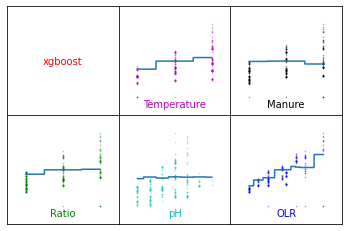

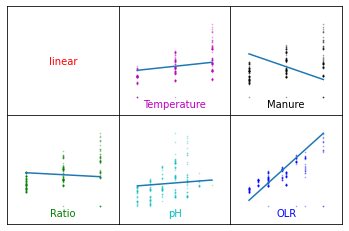

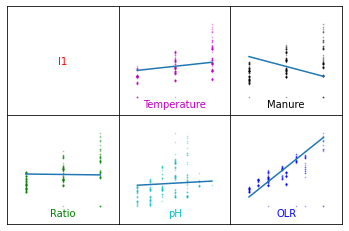

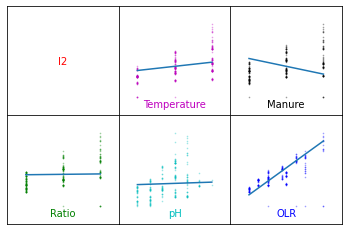

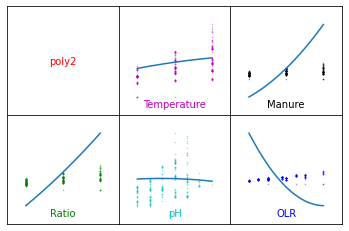

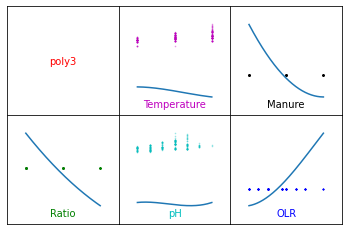

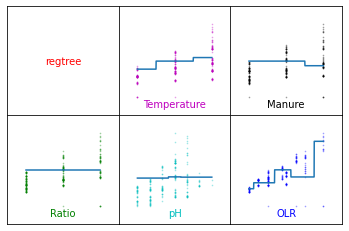

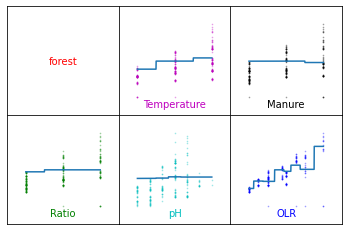

In [8]:
models = ['xgboost', 'linear', 'l1', 'l2', 'poly2',  'poly3', 'regtree', 'forest']
for model in models:
    plot_model_variables(df, model)